In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from string import digits
from matplotlib import pyplot

## import sklearn tools for building and scoring the model
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler

## import Regressors from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor

#### How is the prediction task defined? And what is the meaning of the output variable?
#### ‎ 
##### The prediction task here is to predict the prices of computers based on their configuration

### Data Preprocessing

In [2]:
df = pd.read_csv('pc_data (regression).csv')

In [3]:
brandDF = pd.DataFrame(columns=['Brand'])
typeDF = pd.DataFrame(columns=['Type'])
osDF = pd.DataFrame(columns=['OS'])
priceDF = pd.DataFrame(columns=['Price'])
ssDF = pd.DataFrame(columns=['Screen Size'])

brand = df['Brand']
typee = df['Type']
os = df['Operating System']
price = df['Price ($)']
ss = df['Screen Size']

for i in range(len(brand)):
    brandDF.loc[i] = [brand[i]]
    typeDF.loc[i] = [typee[i]]
    osDF.loc[i] = [os[i]]
    priceDF.loc[i] = [price[i]]
    ssDF.loc[i] = [ss[i]]

In [4]:
## Set feature Array X and target array y
X = df.drop(['Product ID', 'Price ($)'], axis=1)
y = df['Price ($)']

In [5]:
## check for null values
df.isna().sum().sum()

0

In [26]:
df.head()

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040


#### How do you represent your data as features ?
#### Did you process the features in any way?
### ‎ 
##### In this dataset, many of the columns are multi-valued cells, and many contain a mix of categorical and numerical values. In order to prepare the dataset for regression, many of the columns have been split and manipulated. 
##### ‎ 
##### For example, columns such as RAM, where the 'GB' attached to the end of the integer is redundant, have been stripped off every cell in the column to turn it into a numerical attribute. 
##### Furthermore, columns such as CPU, which contain multiple different types of data have been split into seperate columns for greater statistical inference. Columns such as 'Hard Disk', with many of the cells containing more than one value seperated by a '+', have been split into 2 columns instead. 
##### As there are no null values in the dataset, imputation is not necessary. The first column, 'Product ID' is not useful when performing regression, and thus has been dropped from the dataset.
##### ‎ 
##### The data is then split into feature array X, and target array y. X contains every column excluding the target variable y (Price) and y contains only the target variable (Price)

#### Data Wrangling: Hard Disk Column

In [6]:
# DATA WRANGLING ON 'Hard Disk' COLUMN: Hard Disk 1 and Hard Disk 2

## create dataframe to split multi-celled to 2 seperate columns
harddisk = df['Hard Disk']
new_harddisk = []
dff1 = pd.DataFrame(columns=['Hard Disk 1', 'Hard Disk 2'])

## splits record at '+' operator 
for i in range(len(harddisk)):
    new_harddisk.append(harddisk[i].split('+'))
    
## if contains > 1 harddisk, split and reshape into 2 numpy arrays, append to new dataframe
for i in range(len(new_harddisk)):
    split = np.array(new_harddisk[i])
    if (len(split)>1):
        split_arr = np.array(np.split(split, 2))
        splitt = split_arr.reshape(1,2)
        dff1.loc[i] = [splitt[:,0], splitt[:,1]]
    else:
        dff1.loc[i] = [new_harddisk[i],0]
        
        
        
## create dataframe with only integer sizes of storage
column1 = dff1.iloc[:,0]
column2 = dff1.iloc[:,1]
int_dff1 = pd.DataFrame(columns=['HD1 Size', 'HD2 Size'])


for i in range(len(column1)):
    s1 = re.search(r"\d+(\.\d+)?", str(column1[i]))
    s1 = s1.group(0)
    
    if (column2[i] != 0):
        s2 = re.search(r"\d+(\.\d+)?", str(column1[i]))
        s2 = s2.group(0)
        int_dff1.loc[i] = [s1, s2]
    else:
        int_dff1.loc[i] = [s1, 0]
        
int_dff1['HD1 Size'] = int_dff1['HD1 Size'].astype('float')
int_dff1['HD2 Size'] = int_dff1['HD2 Size'].astype('float')
int_dff1

C:\Users\rutsm\AppData\Local\Temp/ipykernel_17764/610484670.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (column2[i] != 0):


,HD1 Size,HD2 Size
0,128.0,0.0
1,128.0,0.0
2,256.0,0.0
3,512.0,0.0
4,256.0,0.0
...,...,...
15315,128.0,0.0
15316,512.0,0.0
15317,64.0,0.0
15318,1.0,0.0


In [7]:
## create dataframe consisting of only type (SSD/HDD/FS)
sizeDF = pd.DataFrame(columns=['HD1', 'HD2'])
HD1sizeDF = pd.DataFrame(columns=['HD1 Storage Type'])
HD2sizeDF = pd.DataFrame(columns=['HD2 Storage Type'])

column1 = dff1.iloc[:,0]
column2 = dff1.iloc[:,1]

for i in range(len(column1)):
    split = column1[i]
    split = str(split).split(' ', 1)[1]
    HD1sizeDF.loc[i] = [split[:-2]]

for i in range(len(column2)):
    split = column2[i]
    if split != 0:
        split = str(split).split(' ', 1)[1]
        split = split[:-2]
        split = split.split(' ')[2]
        HD2sizeDF.loc[i] = [split]
    else:
        HD2sizeDF.loc[i] = [0]
        
HD1sizeDF['HD1 Storage Type'] = HD1sizeDF['HD1 Storage Type'].astype('string')
HD2sizeDF['HD2 Storage Type'] = HD2sizeDF['HD2 Storage Type'].astype('string')
HD2sizeDF

C:\Users\rutsm\AppData\Local\Temp/ipykernel_17764/3892005268.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if split != 0:


,HD2 Storage Type
0,0
1,0
2,0
3,0
4,0
...,...
15315,0
15316,0
15317,0
15318,0


In [8]:
## create dataframe consisting of only unit (GB/TB)
HD1unitDF = pd.DataFrame(columns=['HD1 Unit'])
HD2unitDF = pd.DataFrame(columns=['HD2 Unit'])

for i in range(len(column1)):
    table = str.maketrans('', '', digits)
    newstring1 = str(column1[i]).translate(table)
    split1 = newstring1[2:4]
    HD1unitDF.loc[i] = [split1]
    
    if column2[i] != 0:
        table = str.maketrans('', '', digits)
        newstring2 = str(column2[i]).translate(table)
        split2 = newstring2[2:4]
        HD2unitDF.loc[i] = [split2]
        
    else:
        HD2unitDF.loc[i] = [0]
        
HD1unitDF['HD1 Unit'] = HD1unitDF['HD1 Unit'].astype('string')
HD2unitDF['HD2 Unit'] = HD2unitDF['HD2 Unit'].astype('string')
HD1unitDF

C:\Users\rutsm\AppData\Local\Temp/ipykernel_17764/502769409.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if column2[i] != 0:


,HD1 Unit
0,GB
1,GB
2,GB
3,GB
4,GB
...,...
15315,GB
15316,GB
15317,GB
15318,TB


#### Data Wrangling: RAM Column

In [9]:
## DATA WRANGLING ON 'RAM' COLUMN

ram = df['RAM']
dff2 = pd.DataFrame(columns=['RAM'])

for i in range(len(ram)):
    s = re.search(r"\d+(\.\d+)?", ram[i])
    s = s.group(0)
    dff2.loc[i] = [s]

dff2['RAM'] = dff2['RAM'].astype('int')
dff2

,RAM
0,8
1,8
2,8
3,16
4,8
...,...
15315,4
15316,16
15317,2
15318,6


#### Data Wrangling: Weight Column

In [10]:
## DATA WRANGLING ON 'Weight' COLUMN

weight = df['Weight']
dff3 = pd.DataFrame(columns=['Weight'])

for i in range(len(weight)):
    s = re.search(r"\d+(\.\d+)?", weight[i])
    s = s.group(0)
    dff3.loc[i] = [s]

dff3['Weight'] = dff3['Weight'].astype('float')
dff3

,Weight
0,1.37
1,1.34
2,1.86
3,1.83
4,1.37
...,...
15315,1.80
15316,1.30
15317,1.50
15318,2.19


#### Data Wrangling: GPU Column

In [11]:
## DATA WRANGLING ON 'GPU' COLUMN

## create dataframe containing only brand of GPU
gpu = df['GPU']
gpu_brand = pd.DataFrame(columns=['GPU Brand'])

for i in range(len(gpu)):
    split = gpu[i]
    split = split.split(' ')
    gpu_brand.loc[i] = [split[0]]
    
gpu_brand['GPU Brand'] = gpu_brand['GPU Brand'].astype('string')
gpu_brand

,GPU Brand
0,Intel
1,Intel
2,Intel
3,AMD
4,Intel
...,...
15315,Intel
15316,Intel
15317,Intel
15318,AMD


In [12]:
## create dataframe containing only description of GPU (excludes Brand of GPU)
gpu_desc = pd.DataFrame(columns=['GPU Desc'])

split = gpu[0]
split = split.split(' ', 1)[1]

for i in range(len(gpu)):
    split = gpu[i]
    split = split.split(' ', 1)[1]
    gpu_desc.loc[i] = split
    
gpu_desc['GPU Desc'] = gpu_desc['GPU Desc'].astype('string')
gpu_desc

,GPU Desc
0,Iris Plus Graphics 640
1,HD Graphics 6000
2,HD Graphics 620
3,Radeon Pro 455
4,Iris Plus Graphics 650
...,...
15315,HD Graphics 520
15316,HD Graphics 520
15317,HD Graphics
15318,Radeon R5 M330


#### Data Wrangling: CPU Column

In [13]:
## DATA WRANGLING ON 'CPU' COLUMN

## create dataframe consisting of only CPU Brand
cpu = df['CPU']
cpu_brand = pd.DataFrame(columns=['CPU Brand'])

for i in range(len(gpu)):
    split = cpu[i]
    split = split.split(' ')
    cpu_brand.loc[i] = [split[0]]
    
cpu_brand['CPU Brand'] = cpu_brand['CPU Brand'].astype('string')
cpu_brand

,CPU Brand
0,Intel
1,Intel
2,Intel
3,Intel
4,Intel
...,...
15315,Intel
15316,Intel
15317,Intel
15318,Intel


In [14]:
## create dataframe consisting of only CPU Clock Speed
cpu = df['CPU']
cpu_clockspeed = pd.DataFrame(columns=['CPU Clockspeed'])

for i in range(len(cpu)):
    split = cpu[i]
    split = split.split(' ')
    split = split[-1]
    split = split[:-3]
    cpu_clockspeed.loc[i] = [split]
    
cpu_clockspeed['CPU Clockspeed'] = cpu_clockspeed['CPU Clockspeed'].astype('float')
cpu_clockspeed

,CPU Clockspeed
0,2.3
1,1.8
2,2.5
3,2.7
4,3.1
...,...
15315,2.5
15316,2.5
15317,1.6
15318,2.5


In [15]:
## create dataframe consisting of only CPU Desc
cpu_desc = pd.DataFrame(columns=['CPU_Desc'])

for i in range(len(cpu)):
    split = cpu[i]
    split = split.split(' ', 1)[1:3]
    split = str(split).rsplit(' ', 1)[0]
    cpu_desc.loc[i] = [split[2:]]
    

cpu_desc['CPU_Desc'] = cpu_desc['CPU_Desc'].astype('string')

#### Data Wrangling: CPU Column

In [16]:
## DATA WRANGLING ON 'Screen Specs' COLUMN

## create dataframe consisting of only binary values indicating whether IPS or not
screen_specs = df['Screen Specs']
ips = pd.DataFrame(columns=['IPS'])

for i in range(len(screen_specs)):
    if 'IPS' not in screen_specs[i]:
        ips.loc[i] = [0]
    else:
        ips.loc[i] = [1]

ips['IPS'] = ips['IPS'].astype('int')

In [17]:
## create dataframe consisting of only resolution
resolution = pd.DataFrame(columns=['Resolution'])

for i in range(len(screen_specs)):
    split = screen_specs[i]
    split = split.split(' ')
    resolution.loc[i] = [split[-1]]


resolution['Resolution'] = resolution['Resolution'].astype('string')

In [18]:
## create dataframe consisting of only binary values indicating whether touchscreen or not
touchscreen = pd.DataFrame(columns=['Touchscreen'])

for i in range(len(screen_specs)):
    if 'Touchscreen' not in screen_specs[i]:
        touchscreen.loc[i] = 0
    else:
        touchscreen.loc[i] = 1
    
touchscreen['Touchscreen'] = touchscreen['Touchscreen'].astype('int')

In [19]:
screen_desc = pd.DataFrame(columns=['Desc'])

for i in range(len(screen_specs)):
    split = screen_specs[i]
    
    if (len(split) > 9):
        split = split.rsplit(' ', 1)[0]
        screen_desc.loc[i] = [split]
        
        if 'IPS' in split:
            split = split.split('IPS Panel ')
            
            if len(split) > 1:
                split = split[1]
                screen_desc.loc[i] = [split]
                
                if 'T' in split:
                    split = split.split('/')
                    screen_desc.loc[i] = [split]
                    
                    if str(split).startswith('T') == True:
                        screen_desc.loc[i] = [split[1]]
                    else: 
                        screen_desc.loc[i] = [split[0]]
            else:
                screen_desc.loc[i] = [split]
            
        
    else:
        screen_desc.loc[i] = [0]
        


screen_desc['Desc'] = screen_desc['Desc'].astype('string')
screen_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15320 entries, 0 to 15319
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Desc    15320 non-null  string
dtypes: string(1)
memory usage: 239.4 KB


#### Data Wrangling: Concatenation to form creation of new DataFrame

In [20]:
dataframes = [brandDF, typeDF, ssDF, ips, touchscreen, resolution, screen_desc, cpu_brand, cpu_clockspeed, 
              cpu_desc, gpu_brand, gpu_desc, dff2, int_dff1, HD1sizeDF, HD2sizeDF, HD1unitDF, HD2unitDF, osDF, dff3, priceDF]

df2 = pd.concat(dataframes, axis=1)
df2.to_csv('df2.csv')

In [27]:
df2

,Brand,Type,Screen Size,IPS,Touchscreen,Resolution,Desc,CPU Brand,CPU Clockspeed,CPU_Desc,...,RAM,HD1 Size,HD2 Size,HD1 Storage Type,HD2 Storage Type,HD1 Unit,HD2 Unit,OS,Weight,Price
0,Apple,Ultrabook,13.3,1,0,2560x1600,Retina Display,Intel,2.3,Core i5,...,8,128.0,0.0,SSD,0,GB,0,macOS,1.37,0.298571
1,Apple,Ultrabook,13.3,0,0,1440x900,0,Intel,1.8,Core i5,...,8,128.0,0.0,Flash Storage,0,GB,0,macOS,1.34,-0.330885
2,HP,Notebook,15.6,0,0,1920x1080,Full HD,Intel,2.5,Core i5 7200U,...,8,256.0,0.0,SSD,0,GB,0,No OS,1.86,-0.793519
3,Apple,Ultrabook,15.4,1,0,2880x1800,Retina Display,Intel,2.7,Core i7,...,16,512.0,0.0,SSD,0,GB,0,macOS,1.83,2.009149
4,Apple,Ultrabook,13.3,1,0,2560x1600,Retina Display,Intel,3.1,Core i5,...,8,256.0,0.0,SSD,0,GB,0,macOS,1.37,0.961103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,Lenovo,2 in 1 Convertible,14.0,1,1,1920x1080,Full HD,Intel,2.5,Core i7 6500U,...,4,128.0,0.0,SSD,0,GB,0,Windows 10,1.80,-0.699916
15316,Lenovo,2 in 1 Convertible,13.3,1,1,3200x1800,Quad HD+,Intel,2.5,Core i7 6500U,...,16,512.0,0.0,SSD,0,GB,0,Windows 10,1.30,0.529719
15317,Lenovo,Notebook,14.0,0,0,1366x768,0,Intel,1.6,Celeron Dual Core N3050,...,2,64.0,0.0,Flash Storage,0,GB,0,Windows 10,1.50,-1.284029
15318,HP,Notebook,15.6,0,0,1366x768,0,Intel,2.5,Core i7 6500U,...,6,1.0,0.0,HDD,0,TB,0,Windows 10,2.19,-0.519970


In [21]:
X = df2.drop(['Price'], axis=1)

price_mean = df2['Price'].mean()
price_std = df2['Price'].std()
df2['Price'] = (df2['Price'] - price_mean) / price_std

y = df2['Price']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### How did you select which learning algorithms to use?
##### ‎ 
##### To select which learning algorithms to use, the problem domain is first identified. As this is a regression task, the following learning algorithms were selected: LinearRegression, DecisionTreeRegressor and SVR
##### ‎ 
##### Linear Regression is simple to implement and less complex as compared to other algorithms, as it assumes that there is a linear relationship among variables. However, it is heavily affected by outliers and can be easily prone to overfitting. This can be avoided by dimensionality reduction, cross validation and regularization
##### ‎ 
##### Decision Tree is easy to understand and interpret, and works well with both numerical and categorical data. However it is extremely easy to overfit using this model and is hard to scale as a small change in data can create instability in the tree structure
##### ‎ 
##### SVR is a model that is robust to outliers and often yields a high prediction accuracy. However, they output performance significantly plummets with larger datasets and noisy data

   ### Encoding Categorical Attributes + Fitting into Pipeline

In [31]:
trf1 = ColumnTransformer([
    ('encode1', OneHotEncoder(handle_unknown='ignore', sparse=False), 
     [0, 1, 5, 6, 7, 8, 9, 10, 11,15, 16, 17, 18, 19])
], remainder='passthrough')

model_names = ['LinearRegression', 'DecisionTreeRegressor', 'SVR']
models = [LinearRegression(), DecisionTreeRegressor(), SVR()]
scores_df = pd.DataFrame()


for i in range(len(models)):
    pipeline = Pipeline([('trf1', trf1), ('StandardScaler', StandardScaler()), ('models', models[i])])
    pipeline.fit(X_train, y_train)
    scores = cross_val_score(pipeline, X, y, cv=3)
    
    y_pred = pipeline.predict(X_test)
    y_pred_mean = y_pred.mean()
    y_pred_mean_true = (y_pred_mean*price_std) + price_mean
    
    rsq = pipeline.score(X_test, y_test)
    adj_rsq = 1 - ( 1-pipeline.score(X_test, y_test) ) * (len(y_test) - 1 ) / (len(y_test) - X_test.shape[1] - 1 )
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    y_pred_train = pipeline.predict(X_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    
    print('\n' + str(model_names[i]))
    print('train mse:' + str(train_mse))
    print('test mse:' + str(mse))
    
    scores_df = scores_df.append({'Model': model_names[i],
                               'Predicted(Mean)': y_pred_mean_true,
                               'R Squared': rsq,
                               'Adj. R Squared': adj_rsq,
                               'Mean Absolute Error': mae,
                               'Mean Squared Error': mse,
                               'RMSE': rmse},
                              ignore_index=True)
    

scores_df


LinearRegression
train mse:0.09028299866404021
test mse:0.09736248419719626

DecisionTreeRegressor
train mse:0.0007820122350135257
test mse:0.0009987240029842314

SVR
train mse:0.03296255032921437
test mse:0.037411635262537025


,Model,Predicted(Mean),R Squared,Adj. R Squared,Mean Absolute Error,Mean Squared Error,RMSE
0,LinearRegression,3049.200334,0.908072,0.907650,0.216146,0.097362,0.312030
1,DecisionTreeRegressor,3067.629900,0.999057,0.999053,0.008564,0.000999,0.031603
2,SVR,3063.081810,0.964676,0.964514,0.130584,0.037412,0.193421


##### Above the predicted mean, r squared, mean absolute error, mean squared error and root mean squared error are shown for the respective models.

##### All 3 models performed well, with the Decision Tree Regressor performing exceptionally well, with a r squared of almost 1, and a mean squared error of very close to 0.


### Check For Overfitting

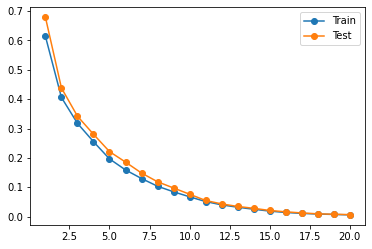

In [34]:
## overfitting in DecisionTreeClassifier()

train_scores, test_scores = list(), list()
values = [i for i in range(1, 21)]

for i in values:
    model = DecisionTreeRegressor(max_depth=i)
    pipeline = Pipeline([('trf1', trf1), ('StandardScaler', StandardScaler()),('model', model)])
    pipeline.fit(X_train, y_train)
    
    test_y_pred = pipeline.predict(X_test)
    test_mse = mean_squared_error(y_test, test_y_pred)
    test_scores.append(test_mse)
    
    train_y_pred = pipeline.predict(X_train)
    train_mse = mean_squared_error(y_train, train_y_pred)
    train_scores.append(train_mse)

pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

##### As Decision Tree Regressor performed the best in all metrics by a landslide, it has been chosen. However, before hypertuning its parameters, first we have to check if the model has been overfitted.

##### The graph shows mean squared error on the y-axis plotted against tree depth on the x-axis. The train line and test line as shown in the graph are almost on top of one another, before converging past level 10.

##### This shows that the model is not overfitted.

### Hyperparameter Tuning With GridSearchCV

In [30]:
## GridSearchCV on DecisionTreeRegressor
pipeline = Pipeline([('trf1', trf1), ('StandardScaler', StandardScaler()), ('lr', DecisionTreeRegressor())])

parameters = parameters={"lr__splitter":("best","random"),
            "lr__max_depth" : (1,3,5,7,9,11,12),
#            "lr__min_samples_leaf": (1,2,3,4,5,6,7,8,9,10),
#            "lr__min_weight_fraction_leaf": (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),
           "lr__max_features": ("auto","log2","sqrt",None),
           "lr__max_leaf_nodes": (None,10,20,30,40,50,60,70,80,90) }

grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs = -1)
grid.fit(X, y)

print(grid.best_score_)
print(grid.best_params_)

0.9613281639273195
{'lr__max_depth': 12, 'lr__max_features': 'auto', 'lr__max_leaf_nodes': None, 'lr__splitter': 'best'}


C:\Users\rutsm\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


### How well does your system compare to a stupid baseline?
##### ‎ 
##### Below the DummyRegressor() regressor is used, so that we are able to compare the system to a stupid baseline like such. The dummy regressor makes predictions based off very simple rules, and is often used as a baseline to compare to other real regressors to evaluate their performance

### Dummy Regressor

In [56]:
dr = DummyRegressor()
dr.fit(X_train, y_train)
y_pred = dr.predict(X_test)
y_pred_mean = y_pred.mean()
y_pred_mean_true = (y_pred_mean*price_std) + price_mean

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rsq = pipeline.score(X_test, y_test)
adj_rsq = 1 - ( 1-pipeline.score(X_test, y_test) ) * (len(y_test) - 1 ) / (len(y_test) - X_test.shape[1] - 1 )
mae = mean_absolute_error(y_test, y_pred)

print('predicted(mean): ' + str(y_pred_mean_true))
print('mse: ' + str(mse))
print('rmse: ' + str(rmse))
print('rsq: ' + str(rsq))
print('adj_rsq: ' + str(adj_rsq))
print('mae: ' + str(mae))

predicted(mean): 2988.769651480791
mse: 1.0608354358897023
rmse: 1.0299686577220213
rsq: 0.9991773413669202
adj_rsq: 0.9991735644033665
mae: 0.7749503164101958


##### Although the r squared value is excellent, almost 1, the mean squared error, root mean squared error and mean absolute error is significantly worse as compared to the Decision Tree Model. 

### Feature Importance

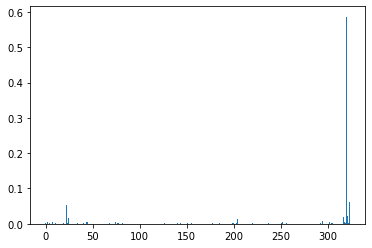

,Feature,Importance
14,14.0,0.028286
22,22.0,0.052304
24,24.0,0.017733
28,28.0,0.013532
80,80.0,0.014275
204,204.0,0.013218
317,317.0,0.020272
320,320.0,0.586328
321,321.0,0.021109
323,323.0,0.061720


In [58]:
# define the model
model = RandomForestRegressor(random_state=42)
# fit the model
pipeline = Pipeline([('trf1', trf1), ('StandardScaler', StandardScaler()), ('model', model)])
pipeline.fit(X, y)
# get importance
importance = model.feature_importances_
array = pd.DataFrame(columns=['Feature', 'Importance'])
# summarize feature importance
for i,v in enumerate(importance):
    array.loc[i] = [i, v]
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

arr = array['Importance']
arr = np.array(arr)

sorted_index_array = np.argsort(arr)
sorted_array = arr[sorted_index_array]
rslt = sorted_array[-10 : ]
rslt = list(rslt)

array.loc[array['Importance'].isin(rslt)]


### References:
##### https://www.analyticsvidhya.com/blog/2021/05/5-regression-algorithms-you-should-know-introductory-guide/
##### https://www.kdnuggets.com/2022/02/random-forest-decision-tree-key-differences.html